In [ ]:
!kaggle datasets download -d tschandl/isic2018-challenge-task1-data-segmentation

Dataset URL: https://www.kaggle.com/datasets/tschandl/isic2018-challenge-task1-data-segmentation
License(s): CC0-1.0
100% 12.9G/12.9G [02:55<00:00, 106MB/s] 
100% 12.9G/12.9G [02:55<00:00, 78.6MB/s]


In [ ]:
!unzip isic2018-challenge-task1-data-segmentation.zip -d /dermascan

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: /dermascan/ISIC2018_Task1-2_Training_Input/ISIC_0000345.jpg  
  inflating: /dermascan/ISIC2018_Task1-2_Training_Input/ISIC_0000346.jpg  
  inflating: /dermascan/ISIC2018_Task1-2_Training_Input/ISIC_0000348.jpg  
  inflating: /dermascan/ISIC2018_Task1-2_Training_Input/ISIC_0000349.jpg  
  inflating: /dermascan/ISIC2018_Task1-2_Training_Input/ISIC_0000350.jpg  
  inflating: /dermascan/ISIC2018_Task1-2_Training_Input/ISIC_0000351.jpg  
  inflating: /dermascan/ISIC2018_Task1-2_Training_Input/ISIC_0000352.jpg  
  inflating: /dermascan/ISIC2018_Task1-2_Training_Input/ISIC_0000353.jpg  
  inflating: /dermascan/ISIC2018_Task1-2_Training_Input/ISIC_0000354.jpg  
  inflating: /dermascan/ISIC2018_Task1-2_Training_Input/ISIC_0000355.jpg  
  inflating: /dermascan/ISIC2018_Task1-2_Training_Input/ISIC_0000357.jpg  
  inflating: /dermascan/ISIC2018_Task1-2_Training_Input/ISIC_0000358.jpg  
  inflating: /dermasca

In [ ]:
#Importation des biblio
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)

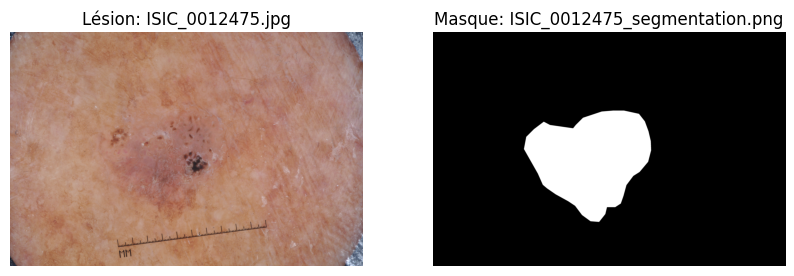

In [ ]:
# Fonction pour afficher 5 images de lésions et leurs masques associés
def display_lesion_images_with_masks(image_folder, mask_folder):
    # Lister les fichiers d'image dans le dossier des lésions
    image_files = [f for f in os.listdir(image_folder) if f.startswith('ISIC') and f.endswith('.jpg')]

    # Limiter à 5 images
    for img_file in image_files[:1]:
        # Extraire l'identifiant de l'image
        image_id = img_file.split('.')[0]  # Par exemple, "ISIC_1234567"

        # Construire les chemins complets des images et des masques
        img_path = os.path.join(image_folder, img_file)
        mask_file = f"{image_id}_segmentation.png"
        mask_path = os.path.join(mask_folder, mask_file)

        # Lire l'image de la lésion
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir de BGR à RGB

        # Vérifier si le masque correspondant existe et le lire
        if os.path.exists(mask_path):
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Lire le masque en niveaux de gris
        else:
            print(f"Masque non trouvé pour l'image : {img_file}")
            continue

        # Afficher l'image de la lésion et son masque
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 ligne, 2 colonnes
        axs[0].imshow(img_rgb)
        axs[0].set_title(f"Lésion: {img_file}")
        axs[0].axis('off')  # Cacher les axes

        axs[1].imshow(mask, cmap='gray')
        axs[1].set_title(f"Masque: {mask_file}")
        axs[1].axis('off')  # Cacher les axes

        plt.show()

# Exemple d'utilisation
image_folder = '/dermascan/ISIC2018_Task1-2_Training_Input'
mask_folder = '/dermascan/ISIC2018_Task1_Training_GroundTruth'
display_lesion_images_with_masks(image_folder, mask_folder)


In [ ]:
# Redimensionnement et normalisation des images
def preprocess_image(image, img_size=(128, 128)):
    if image is None:
        return None
    # Redimensionner l'image
    resized_image = cv2.resize(image, img_size)
    # Normaliser les valeurs des pixels entre 0 et 1
    normalized_image = resized_image / 255.0
    return normalized_image

# Prétraitement des masques de segmentation
def preprocess_mask(mask, img_size=(128, 128)):
    if mask is None:
        return None
    # Redimensionner le masque
    resized_mask = cv2.resize(mask, img_size)
    # Binariser le masque (les valeurs non nulles deviennent 1)
    binarized_mask = np.where(resized_mask > 0, 1, 0)
    return binarized_mask

# Appliquer le prétraitement à un ensemble d'images et de masques
def preprocess_dataset(image_dir, mask_dir, img_size=(128, 128)):
    images = []
    masks = []

    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))

    for img_file, mask_file in zip(image_files, mask_files):
        # Charger l'image
        img_path = os.path.join(image_dir, img_file)
        image = cv2.imread(img_path)
        preprocessed_image = preprocess_image(image, img_size)
        if preprocessed_image is not None:
            images.append(preprocessed_image)

        # Charger le masque
        mask_path = os.path.join(mask_dir, mask_file)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        preprocessed_mask = preprocess_mask(mask, img_size)
        if preprocessed_mask is not None:
            masks.append(preprocessed_mask)

    images = np.array(images)
    masks = np.array(masks)

    # Assurer que les masques ont une dimension supplémentaire pour les canaux
    masks = masks.reshape(-1, img_size[0], img_size[1], 1)

    return images, masks
images, masks = preprocess_dataset(image_folder, mask_folder)
print(f"Images shape: {images.shape}")
print(f"Masks shape: {masks.shape}")

Images shape: (2594, 128, 128, 3)
Masks shape: (2594, 128, 128, 1)


In [ ]:
!unzip /ISIC2018_Task1_Validation_GroundTruth.zip -d /validation_ground_truth

Archive:  /ISIC2018_Task1_Validation_GroundTruth.zip
   creating: /validation_ground_truth/ISIC2018_Task1_Validation_GroundTruth/
  inflating: /validation_ground_truth/ISIC2018_Task1_Validation_GroundTruth/ATTRIBUTION.txt  
  inflating: /validation_ground_truth/ISIC2018_Task1_Validation_GroundTruth/ISIC_0012255_segmentation.png  
  inflating: /validation_ground_truth/ISIC2018_Task1_Validation_GroundTruth/ISIC_0012346_segmentation.png  
  inflating: /validation_ground_truth/ISIC2018_Task1_Validation_GroundTruth/ISIC_0012576_segmentation.png  
  inflating: /validation_ground_truth/ISIC2018_Task1_Validation_GroundTruth/ISIC_0012585_segmentation.png  
  inflating: /validation_ground_truth/ISIC2018_Task1_Validation_GroundTruth/ISIC_0012623_segmentation.png  
  inflating: /validation_ground_truth/ISIC2018_Task1_Validation_GroundTruth/ISIC_0012627_segmentation.png  
  inflating: /validation_ground_truth/ISIC2018_Task1_Validation_GroundTruth/ISIC_0012633_segmentation.png  
  inflating: /valida

In [ ]:
!wget https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Validation_Input.zip -O /input_validation.zip

--2024-10-18 13:20:27--  https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Validation_Input.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 54.231.202.137, 52.217.131.73, 16.182.108.33, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|54.231.202.137|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 239231159 (228M) [application/zip]
Saving to: ‘/input_validation.zip’

/input_validation.z 100%[===================>] 228.15M  66.6MB/s    in 3.4s    

2024-10-18 13:20:30 (66.6 MB/s) - ‘/input_validation.zip’ saved [239231159/239231159]



In [ ]:
!unzip /input_validation.zip -d /input_validation

Archive:  /input_validation.zip
   creating: /input_validation/ISIC2018_Task1-2_Validation_Input/
  inflating: /input_validation/ISIC2018_Task1-2_Validation_Input/ATTRIBUTION.txt  
  inflating: /input_validation/ISIC2018_Task1-2_Validation_Input/ISIC_0012255.jpg  
  inflating: /input_validation/ISIC2018_Task1-2_Validation_Input/ISIC_0012346.jpg  
  inflating: /input_validation/ISIC2018_Task1-2_Validation_Input/ISIC_0012576.jpg  
  inflating: /input_validation/ISIC2018_Task1-2_Validation_Input/ISIC_0012585.jpg  
  inflating: /input_validation/ISIC2018_Task1-2_Validation_Input/ISIC_0012623.jpg  
  inflating: /input_validation/ISIC2018_Task1-2_Validation_Input/ISIC_0012627.jpg  
  inflating: /input_validation/ISIC2018_Task1-2_Validation_Input/ISIC_0012633.jpg  
  inflating: /input_validation/ISIC2018_Task1-2_Validation_Input/ISIC_0012643.jpg  
  inflating: /input_validation/ISIC2018_Task1-2_Validation_Input/ISIC_0015294.jpg  
 extracting: /input_validation/ISIC2018_Task1-2_Validation_Inpu

In [ ]:
val_img_folder = '/input_validation/ISIC2018_Task1-2_Validation_Input/'
val_mask_folder = '/validation_ground_truth'
val_images, val_masks = preprocess_dataset(val_img_folder, val_mask_folder)
print(f"Validation images shape: {val_images.shape}")
print(f"Validation masks shape: {val_masks.shape}")

Validation images shape: (0,)
Validation masks shape: (0, 128, 128, 1)


In [ ]:
print("Validation images files:", os.listdir(val_img_folder))

Validation images files: ['ISIC_0019334.jpg', 'ISIC_0020953.jpg', 'ISIC_0020893.jpg', 'ISIC_0023755.jpg', 'ISIC_0019049.jpg', 'ISIC_0022657.jpg', 'ISIC_0022192.jpg', 'ISIC_0017755.jpg', 'ISIC_0015480.jpg', 'ISIC_0015462.jpg', 'ISIC_0036174.jpg', 'ISIC_0021037.jpg', 'ISIC_0012346.jpg', 'ISIC_0022738.jpg', 'ISIC_0021202.jpg', 'ISIC_0036121.jpg', 'ISIC_0036281.jpg', 'ISIC_0015518.jpg', 'ISIC_0036240.jpg', 'ISIC_0016804.jpg', 'ISIC_0018680.jpg', 'ISIC_0012623.jpg', 'ISIC_0021448.jpg', 'ISIC_0018472.jpg', 'ISIC_0023904.jpg', 'ISIC_0017702.jpg', 'ISIC_0024135.jpg', 'ISIC_0018111.jpg', 'ISIC_0023831.jpg', 'ISIC_0036101.jpg', 'ISIC_0021904.jpg', 'ISIC_0022221.jpg', 'ISIC_0018611.jpg', 'ISIC_0036085.jpg', 'ISIC_0015552.jpg', 'ISIC_0020999.jpg', 'ISIC_0023924.jpg', 'ISIC_0023628.jpg', 'ISIC_0036073.jpg', 'ISIC_0020233.jpg', 'ATTRIBUTION.txt', 'ISIC_0017341.jpg', 'ISIC_0021251.jpg', 'ISIC_0023936.jpg', 'ISIC_0019723.jpg', 'ISIC_0022029.jpg', 'ISIC_0018556.jpg', 'ISIC_0018375.jpg', 'ISIC_0015492.j

In [ ]:
#Construisons le model u-net
#les encodeurs
def encoder_block(inputs, num_filters):
    # Première convolution suivie d'une ReLU
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(inputs)
    x = tf.keras.layers.Activation('relu')(x)
    # Deuxième convolution suivie d'une ReLU
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Max Pooling
    p = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
    return x, p

In [ ]:
#les décodeurs
def decoder_block(inputs, skip_features, num_filters):
    # Up-convolution (upsampling)
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(inputs)
    # Concaténation avec les features de l'encodeur (skip connection)
    x = tf.keras.layers.Concatenate()([x, skip_features])
    # Première convolution suivie d'une ReLU
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Deuxième convolution suivie d'une ReLU
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [ ]:
# le code du modél Unet
def unet_model(input_shape, num_classes):
    inputs = tf.keras.layers.Input(input_shape)

    # Chemin contractuel (encodeur)
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # Bottleneck
    b1 = tf.keras.layers.Conv2D(1024, 3, padding='same')(p4)
    b1 = tf.keras.layers.Activation('relu')(b1)
    b1 = tf.keras.layers.Conv2D(1024, 3, padding='same')(b1)
    b1 = tf.keras.layers.Activation('relu')(b1)

    # Chemin expansif (décodeur)
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # Couche de sortie
    outputs = tf.keras.layers.Conv2D(num_classes, 1, padding='same', activation='sigmoid')(d4)

    model = tf.keras.models.Model(inputs, outputs, name="U-Net")
    return model

In [ ]:
model = unet_model((128, 128, 3), 1)

model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 128, 128, 64)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 64, 64, 128)    │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activation) │ (None, 32, 32, 256)    │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ activation_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_5 (Activation) │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 256)    │              0 │ activation_5[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_6 (Activation) │ (None, 16, 16, 512)    │              0 │ conv2d_6[0][0]         │
├──────────────────────

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(images,
          masks,
          epochs=10,
          batch_size=16 ,
          validation_split=0.2)

Epoch 1/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 4257s 33s/step - accuracy: 0.8600 - loss: 0.3773 - val_accuracy: 0.7250 - val_loss: 0.5603
Epoch 2/10
 75/130 ━━━━━━━━━━━━━━━━━━━━ 28:05 31s/step - accuracy: 0.8183 - loss: 0.4316